# Population Prediction with XGBoost

This notebook implements population prediction using XGBoost regression.

In [7]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from math import sqrt

## Data Loading and Preprocessing

In [8]:
data = pd.read_csv(r'/home/budhayan/Documents/mic208-assgn/population-prediction/data/indian population new.csv')
useful_data = data[['Year', 'Population', '% Increase in Population']]

def fixdata(string):
    ans = ""
    for i in string:
        if i != ',':
            ans += i
    return int(ans)

useful_data['Population'] = useful_data['Population'].apply(fixdata)
useful_data.head()

,Year,Population,% Increase in Population
0,1950,357021100,0.00%
1,1951,364922360,2.21%
2,1952,372997188,2.21%
3,1953,381227705,2.21%
4,1954,389731406,2.23%


## Feature Engineering for Time Series

In [9]:
def create_features(data, n_lags=5):
    df = data.copy()
    
    for i in range(1, n_lags + 1):
        df[f'Population_lag_{i}'] = df['Population'].shift(i)
    
    df['Year_squared'] = df['Year'] ** 2
    df['Year_cubed'] = df['Year'] ** 3
    
    df = df.dropna()
    
    return df

n_lags = 5
feature_data = create_features(useful_data, n_lags)
feature_data.head()

,Year,Population,% Increase in Population,Population_lag_1,Population_lag_2,Population_lag_3,Population_lag_4,Population_lag_5,Year_squared,Year_cubed
5,1955,398577992,2.27%,389731406.0,381227705.0,372997188.0,364922360.0,357021100.0,3822025,7472058875
6,1956,407656597,2.28%,398577992.0,389731406.0,381227705.0,372997188.0,364922360.0,3825936,7483530816
7,1957,416935399,2.28%,407656597.0,398577992.0,389731406.0,381227705.0,372997188.0,3829849,7495014493
8,1958,426295763,2.25%,416935399.0,407656597.0,398577992.0,389731406.0,381227705.0,3833764,7506509912
9,1959,435900352,2.25%,426295763.0,416935399.0,407656597.0,398577992.0,389731406.0,3837681,7518017079


## Data Splitting

In [19]:
train_size = 60 - n_lags  

X_train = feature_data.drop('Population', axis=1)[:train_size]
y_train = feature_data['Population'][:train_size]

X_test = feature_data.drop('Population', axis=1)[train_size:]
y_test = feature_data['Population'][train_size:]

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 55
Testing set size: 13


## XGBoost Model Training and Hyperparameter Tuning

In [32]:
def tune_xgboost_params():
    best_rmse = float('inf')
    best_params = {}
    
    n_estimators_range = [50, 100, 200]
    max_depth_range = [3, 5, 7]
    learning_rate_range = [0.01, 0.05, 0.1]
    
    X_train_processed = X_train.copy()
    X_test_processed = X_test.copy()
    
    if '% Increase in Population' in X_train_processed.columns:
        X_train_processed['% Increase in Population'] = pd.to_numeric(X_train_processed['% Increase in Population'], errors='coerce')
        X_test_processed['% Increase in Population'] = pd.to_numeric(X_test_processed['% Increase in Population'], errors='coerce')
    
    X_train_processed = X_train_processed.fillna(0)
    X_test_processed = X_test_processed.fillna(0)
    
    for n_estimators in n_estimators_range:
        for max_depth in max_depth_range:
            for learning_rate in learning_rate_range:
                model = XGBRegressor(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    learning_rate=learning_rate,
                    random_state=42,
                    enable_categorical=True 
                )

                y_train_log = np.log1p(y_train)
                y_test_log = np.log1p(y_test)
                
                model.fit(X_train_processed, y_train_log)
                y_pred_log = model.predict(X_test_processed)
                y_pred = np.expm1(y_pred_log)
                rmse = sqrt(mean_squared_error(y_test, y_pred))
                
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'learning_rate': learning_rate
                    }
    
    return best_params, best_rmse

best_params, best_rmse = tune_xgboost_params()
best_params = {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.3}
print(f"Best hyperparameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

Best hyperparameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.3}
Best RMSE: 126532731.43898095


## Train Final XGBoost Model with Best Parameters

In [33]:
xgb_model = XGBRegressor(**best_params, random_state=42, enable_categorical=True)

X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

for col in X_train.select_dtypes(include=['object']).columns:
    if col == '% Increase in Population':
        X_train_processed[col] = pd.to_numeric(X_train_processed[col], errors='coerce')
        X_test_processed[col] = pd.to_numeric(X_test_processed[col], errors='coerce')
    else:
        X_train_processed[col] = X_train_processed[col].astype('category')
        X_test_processed[col] = X_test_processed[col].astype('category')

X_train_processed = X_train_processed.fillna(0)
X_test_processed = X_test_processed.fillna(0)

xgb_model.fit(X_train_processed, y_train)

y_pred = xgb_model.predict(X_test_processed)

rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mpe = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"MPE: {mpe}%")


RMSE: 125091753.09073602
MAE: 111764280.0
R2 Score: -3.9570717811584473
MPE: 8.205658976548877%


## Feature Importance Analysis

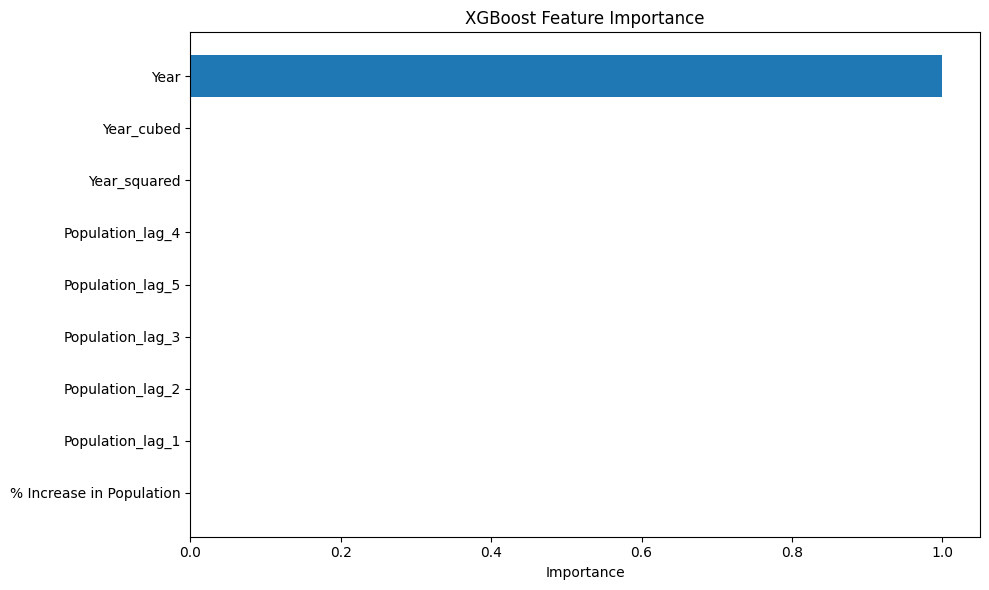

In [14]:
feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## Plot Actual vs Predicted Values

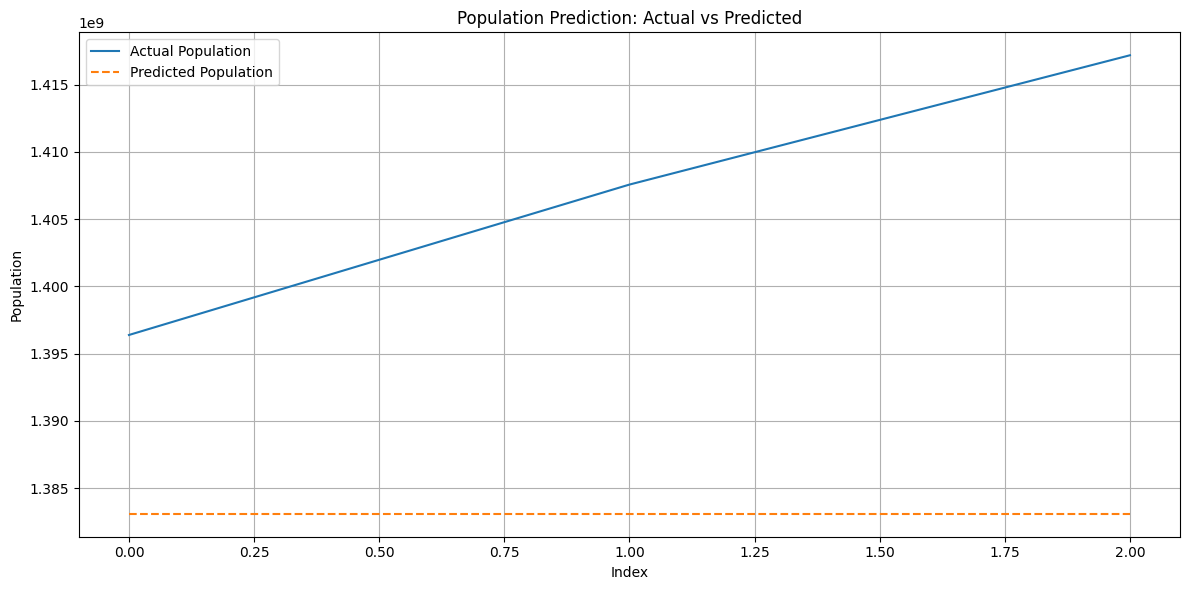

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Population')
plt.plot(y_pred, label='Predicted Population', linestyle='--')
plt.title('Population Prediction: Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Future Population Prediction

In [16]:
def predict_future_population(model, last_data, n_years=10):
    future_predictions = []
    future_years = []
    
    last_year = last_data.iloc[-1]['Year']
    last_n_populations = list(feature_data['Population'].iloc[-n_lags:])
    
    for i in range(1, n_years + 1):
        future_year = last_year + i
        future_years.append(future_year)
        
        features = {}
        features['Year'] = future_year
        features['% Increase in Population'] = 0
        features['Year_squared'] = future_year ** 2
        features['Year_cubed'] = future_year ** 3
        
        for j in range(1, n_lags + 1):
            if j <= len(future_predictions):
                features[f'Population_lag_{j}'] = future_predictions[-j]
            else:
                features[f'Population_lag_{j}'] = last_n_populations[-j + len(future_predictions)]
        
        pred_df = pd.DataFrame([features])
        pred_df = pred_df[X_train.columns]
        
        prediction = model.predict(pred_df)[0]
        future_predictions.append(prediction)
        
    return future_years, future_predictions

future_years, future_predictions = predict_future_population(xgb_model, feature_data, n_years=10)

future_df = pd.DataFrame({
    'Year': future_years,
    'Predicted_Population': future_predictions
})

print("Future Population Predictions:")
print(future_df)

Future Population Predictions:
   Year  Predicted_Population
0  2023          1.383100e+09
1  2024          1.383100e+09
2  2025          1.383100e+09
3  2026          1.383100e+09
4  2027          1.383100e+09
5  2028          1.383100e+09
6  2029          1.383100e+09
7  2030          1.383100e+09
8  2031          1.383100e+09
9  2032          1.383100e+09


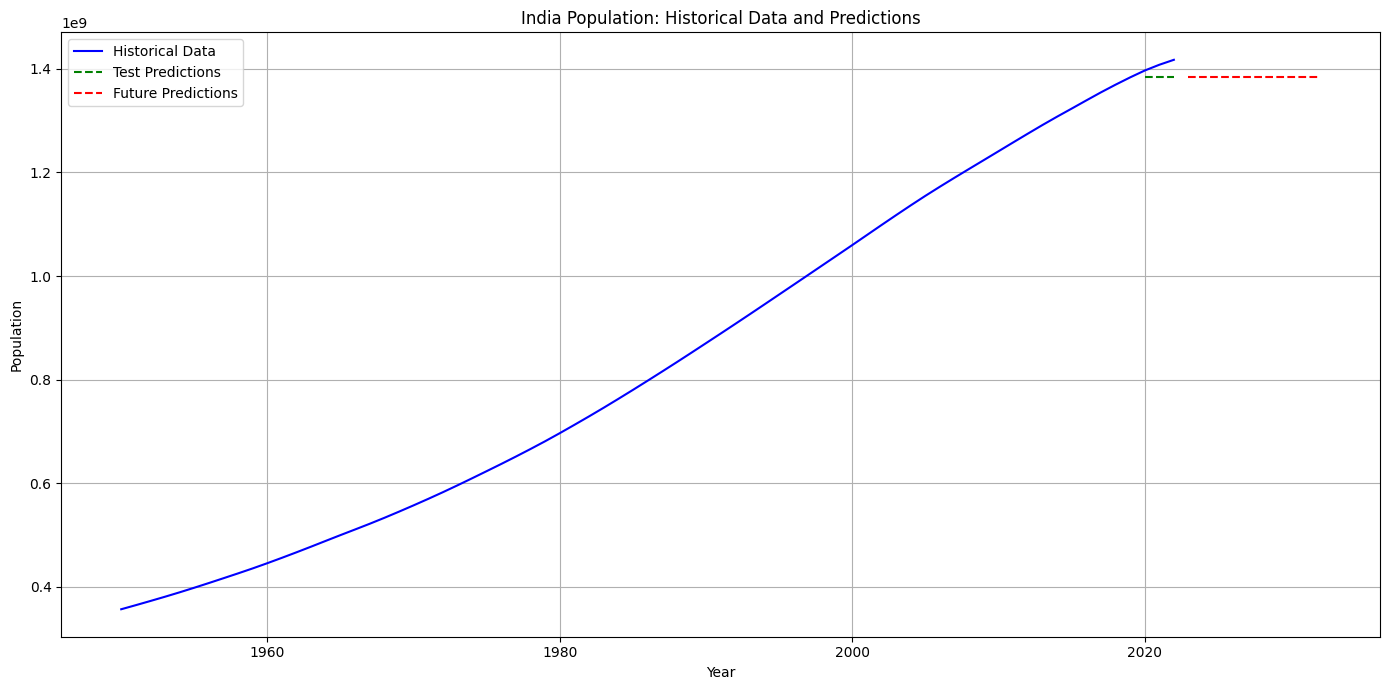

In [17]:
plt.figure(figsize=(14, 7))

plt.plot(useful_data['Year'], useful_data['Population'], 'b-', label='Historical Data')

test_years = feature_data['Year'][train_size:].values
plt.plot(test_years, y_pred, 'g--', label='Test Predictions')

plt.plot(future_years, future_predictions, 'r--', label='Future Predictions')

plt.title('India Population: Historical Data and Predictions')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()